In [30]:
import tensorflow as tf
from tensorflow import keras
from pathlib import Path
import os
import numpy as np
from keras import layers
from matplotlib import pyplot as plt
from datetime import datetime


In [31]:
images = list(Path("./data/").glob("*.png"))+list(Path("./data/").glob("*.jpg"))
images = [str(path) for path in images]
labels = [img.split('/')[-1].split('.')[0] for img in images]
charecters = set(char for label in labels for char in label)
print(charecters)
# print(images[0:100])

{'7', 'y', 'x', '8', 'b', 'n', 'm', '4', '5', '3', 'd', 'p', 'c', 'f', 'g', 'w', 'e', '2', '6'}


In [32]:
#All necessary variables
max_label_len = max([len(label) for label in labels])
img_width = 200
img_height = 50
batch_size = 16

train_split = 0.9

In [33]:
char_to_num = keras.layers.StringLookup(vocabulary=list(charecters), num_oov_indices=1, mask_token=None)
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [34]:
def split_data(x,train_split=0.9,shuffle=True):
    split = int(len(x)*train_split)
    if shuffle:
        import random
        random.shuffle(x)
    return x[:split],x[split:]

img_train,img_test = split_data(np.array(images),train_split=train_split,shuffle=False)
label_train,label_test = split_data(np.array(labels),train_split=train_split,shuffle=False)
print(len(img_train),len(img_test))
print(img_test[0],label_test[0])


963 107
data/mcc2x.png mcc2x


In [35]:
def encode_one_example(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # print(img.shape)
    img = tf.image.resize(img, [img_height, img_width])
    # print(img)
    img = tf.transpose(img, perm=[1, 0, 2])

    label = tf.strings.unicode_split(label, input_encoding='UTF-8')
    # label = tf.constant(list(label))
    label = char_to_num(label)
    return dict(image=img, label=label)
dic = encode_one_example(img_train[0], label_train[0])
print(dic['image'].shape)


(200, 50, 1)


In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, label_train))
train_dataset = (
    train_dataset.map(
        encode_one_example, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, label_test))
test_dataset = (
    test_dataset.map(
        encode_one_example, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
# print(train_dataset)

In [37]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

def inception_block(x,filters=[32,16,32,64,16,8]):
    x3 = layers.Conv2D(filters=filters[-1],kernel_size=1,padding='same',activation='relu')(x)
    x3 = layers.Conv2D(filters=filters[0],kernel_size=3,padding='same',activation='relu')(x3)

    x5 = layers.Conv2D(filters=filters[-1],kernel_size=1,padding='same',activation='relu')(x)
    x5 = layers.Conv2D(filters=filters[1],kernel_size=5,padding='same',activation='relu')(x5)

    x33 = layers.Conv2D(filters=filters[-1],kernel_size=1,padding='same',activation='relu')(x)
    x33 = layers.Conv2D(filters=filters[2],kernel_size=3,padding='same',activation='relu')(x33)
    x33 = layers.Conv2D(filters=filters[3],kernel_size=3,padding='same',activation='relu')(x33)

    branch_pool = layers.MaxPooling2D(3, strides=1, padding='same')(x)
    branch_pool = layers.Conv2D(filters[4], 1,padding='same', activation='relu')(branch_pool)

    output = layers.Concatenate(axis=-1)([x3,x5,x33,branch_pool])
    return output

In [38]:
def build_model():
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image", dtype="float32")
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    x = layers.Conv2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)
    x = inception_block(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((img_width // 4), -1)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    x = layers.Dense(len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2")(x)

    output = CTCLayer(name="ctc_loss")(labels, x)

    model = keras.Model(inputs=[input_img, labels], outputs=output, name="ocr_model")
    model.compile(optimizer=keras.optimizers.Adam())
    return model


ocr_model = build_model()
ocr_model.summary()

Model: "ocr_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)          (None, 100, 25, 8)           264       ['pool1[0][0]']               
                                                                                          

In [39]:
epochs = 100
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = ocr_model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

ocr_model.save(f'model{datetime.now().strftime("%Y%m%d%H%M%S")}.keras')

Epoch 1/100
61/61 [==============================] - 26s 211ms/step - loss: 20.8076 - val_loss: 16.3441
Epoch 2/100
61/61 [==============================] - 10s 170ms/step - loss: 16.3543 - val_loss: 16.3512
Epoch 3/100
61/61 [==============================] - 10s 165ms/step - loss: 16.3348 - val_loss: 16.3526
Epoch 4/100
61/61 [==============================] - 10s 168ms/step - loss: 16.3228 - val_loss: 16.3611
Epoch 5/100
61/61 [==============================] - 10s 172ms/step - loss: 16.3074 - val_loss: 16.3490
Epoch 6/100
61/61 [==============================] - 10s 166ms/step - loss: 16.2844 - val_loss: 16.3258
Epoch 7/100
61/61 [==============================] - 10s 170ms/step - loss: 16.2556 - val_loss: 16.3000
Epoch 8/100
61/61 [==============================] - 10s 167ms/step - loss: 16.1998 - val_loss: 16.2611
Epoch 9/100
61/61 [==============================] - 11s 184ms/step - loss: 16.1323 - val_loss: 16.2860
Epoch 10/100
61/61 [==============================] - 11s 184ms/

In [40]:
def decode_batch_predictions(pred):
    input_len = tf.ones(pred.shape[0]) * pred.shape[1]

    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)
    results = results[0][0]

    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        result = result.replace("[UNK]", "").strip()
        output_text.append(result)
    return output_text


1/1 [==============================] - 2s 2s/step
(16, 50, 21)


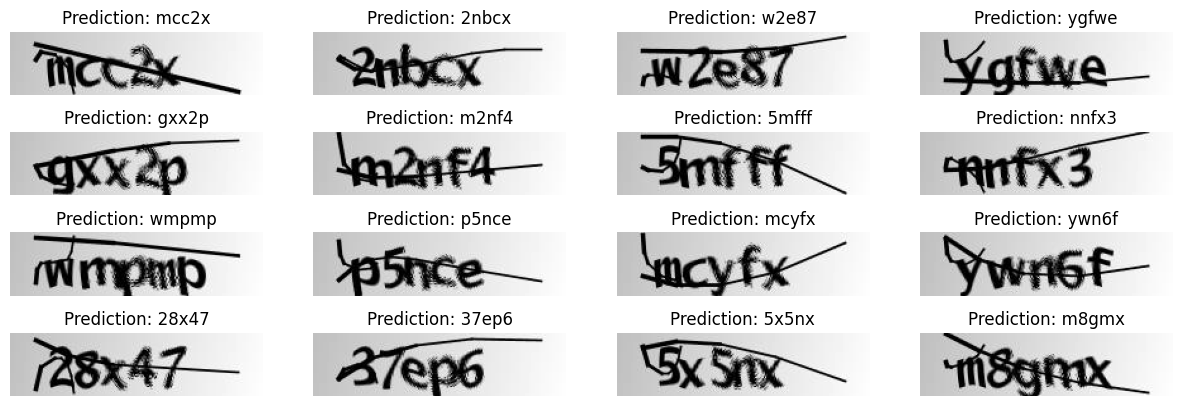

In [41]:
prediction_model = keras.models.Model(
    ocr_model.input[0], ocr_model.get_layer(name="dense2").output
)
# prediction_model.summary()



for batch in test_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    print(preds.shape)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

In [42]:
def encode_one_for_testing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, channels=1, expand_animations=False)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])
    return tf.expand_dims(img,0)


print(img_test[0])
x = encode_one_for_testing(img_test[0])
print(x.shape)
pred_test = prediction_model.predict(x)
final_pred = decode_batch_predictions(pred_test)
print(final_pred[0],label_test[0])
print(img_test[0])

data/mcc2x.png
(1, 200, 50, 1)
1/1 [==============================] - 0s 48ms/step
mcc2x mcc2x
data/mcc2x.png


In [43]:
prediction_model.summary()
prediction_model.save('first_prediction_model.keras')

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 50, 1)]         0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 200, 50, 32)          320       ['image[0][0]']               
                                                                                                  
 pool1 (MaxPooling2D)        (None, 100, 25, 32)          0         ['Conv1[0][0]']               
                                                                                                  
 conv2d_20 (Conv2D)          (None, 100, 25, 8)           264       ['pool1[0][0]']               
                                                                                            